In [1]:
import sys
import numpy as np
import pandas as pd
from fortran import fortran
from scipy.constants import pi, Boltzmann as kb
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# VARIABLE MCS

In [3]:
# ============= DECLARING FORTRAN SUBROUTINES =============
abc = fortran.subr1           # Metropolis algorithm
HextCalc = fortran.subr2      # Setting hex value
randomArrays = fortran.subr3  # Create de position, mag and ku arrays at random (Initial configuration)
magTotalSet = fortran.subr4   # Calculating total magnetic field

In [4]:
# ============= DEFINING FIXED PARAMETERS =================
n = 1000                        # Number of nanoparticles
Hmax = 1                        # Magnetic Field (Tesla)
nHstep = 200                    # Number of steps for the field
kuni = 4.7e5                    # Uniaxial anisotropy constant in J/m³
Ms = 1400e3                     # Saturation magnetization in A/m
d = 5e-9                        # Diameter of the nanoparticles in m
nHext = int(5*nHstep/2-2)       # Number of points in M(H) curve


# ============= DEFINING DYNAMIC PARAMETERS =================
mcs = 40                        # Monte Carlo steps
dThet = 20                      # Solid angle for transitions
dThet = dThet*pi/180.0
temp = 100                      # Temperature in Kelvin
Hext = 0.0
magTotal = 0.0

# ============= DECLARING ARRAYS ==========================
mag = np.empty(shape=(int(n),3), order='F')
ku = np.empty(shape=(int(n),3), order='F')
xyz = np.empty(shape=(int(n),3), order='F')
vecH = np.empty(shape=(1,3), order='F')
mhCurve = np.empty(shape=(nHext+1,2), order='F')
initConf = np.empty(shape=(int(n),3), order='F')

# ============= INITIAL CONFIGURATION =====================  
vecH = np.array([0.0,0.0,1.0])  # FIELD DIRECTION
mag, ku, xyz = randomArrays(pi,n)
for i in range(0,n):
    initConf[i] = mag[i]
# FILLIN FILES magData.txt and xyzData.txt
with open("magData.txt","wb") as file:
    np.savetxt(file,mag,delimiter="\t")
with open("xyzData.txt","wb") as file:
    np.savetxt(file,xyz,delimiter="\t")    
# ERASING TRASH DATA IN mhData.txt, this is the M(H) curve data to be plotted
with open("mhData.txt", "w"):
    pass

# ============= CREATING DATAFRAME FOR ARRAYS =============
dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) 
dfXyz = pd.DataFrame(data=xyz[0:,0:],columns=['x','y','z']) 

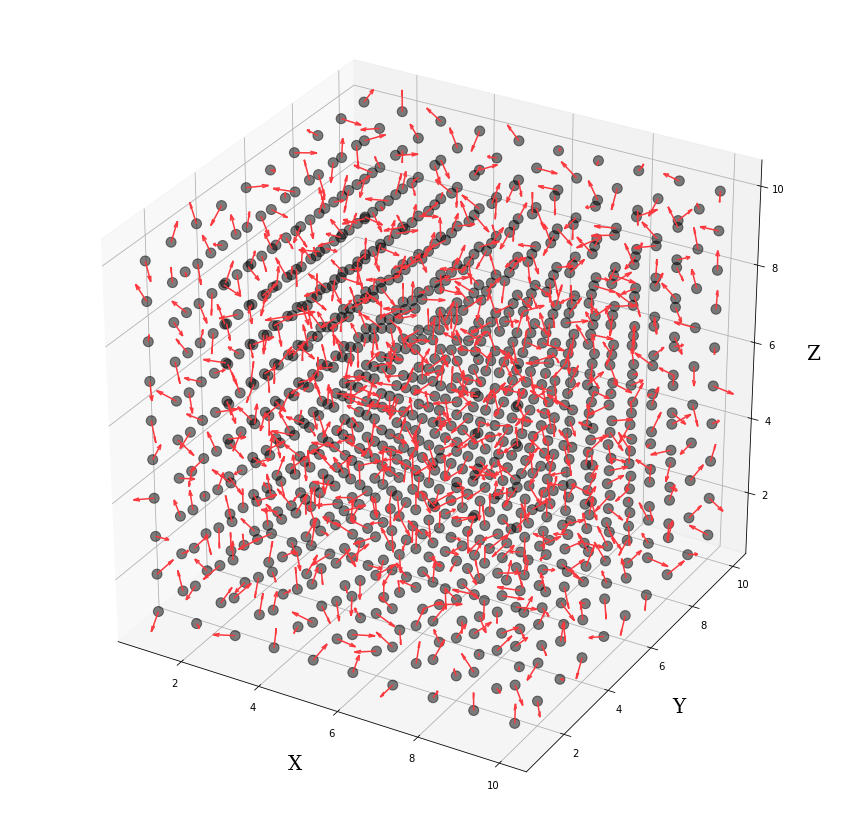

In [5]:
# ============= PLOTTING INITIAL CONFIGURATION =============
#Normal 3D plot
%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=0.5, color="k")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.5, color='#FC383E')
#ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
plt.savefig('3d.png')
plt.show()

In [6]:
# SETTING magTotal
magTotal = magTotalSet(mag, vecH,n)
# FILLING DATAFRAME AND ARRAY
df = pd.DataFrame([
    [Hext, magTotal]
], columns = ["Hext", "MagTotal"])

In [7]:
# ============= DYNAMIC MCS (STEP = 100) ============= 

for temp in range(20,101,20):
    mcstep = 750

    while mcstep < 1001:
    #for mcstep in range (20,100,20):

        #RESTARTING DYNAMIC VARIABLES
        mcs = mcstep                      
        Hext = 0.00
        magTotal = 0.00
        mag = np.empty(shape=(int(n),3))
        for i in range(0,n):
            mag[i] = initConf[i]
        #dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) 
        #NAMING NEW FILE
        filename = "temp" + str(temp) + "/mcs" + str(mcs)
        #RECREATING ARRAY FOR M(H) DATA
        mhCurve = np.empty(shape=(nHext+1,2))
        mhCurve[0,0] = Hext
        mhCurve[0,1] = magTotal
        with open(filename, "w"):
            pass
        # SETTING magTotal AND DATAFRAME USING MARKOV CHAINS
        for i in range(0,nHext):    
            Hext = HextCalc(Hext,nHstep,Hmax,i)   
            for step in range(0,int(mcs)):
                for nanoparticle in range(0,int(n)):
                    randN = round(np.random.rand()*(n-1)) #Random Nanoparticle
                    mag[randN] = abc(vecH, Hext, dThet, ku[randN], pi, mag[randN], d, kuni, Ms, kb, temp)   

            # FILLING FILE magData.txt FOR 3D-PLOT
            # with open("magData.txt","wb") as file:
                # np.savetxt(file,mag,delimiter="\t")      

            magTotal = magTotalSet(mag, vecH,n)   
            print(i,Hext,magTotal)
            df.loc[i+1]=[Hext,magTotal]
            # FILLING FILE mhData.txt
            mhCurve[i+1,0] = Hext
            mhCurve[i+1,1] = magTotal
            with open(filename,'wb') as file:
                np.savetxt(file,mhCurve,delimiter="\t")
        #if mcstep < 100:
        #    mcstep = mcstep + 20
        #else:
        #    mcstep = mcstep + 100
        mcstep = mcstep + 250

0 0.01 14.472958877583132
1 0.02 22.064606322525133
2 0.03 29.415483680545975
3 0.04 39.01698369786207
4 0.05 43.28703169324229
5 0.060000000000000005 50.14572822312669
6 0.07 59.15253942724008
7 0.08 67.26731321692806
8 0.09 74.64825837504138
9 0.09999999999999999 83.31177731834096
10 0.10999999999999999 92.17766518017086
11 0.11999999999999998 97.85993653068117
12 0.12999999999999998 107.56014342631595
13 0.13999999999999999 115.58583944940564
14 0.15 121.74844390581923
15 0.16 129.09519838058876
16 0.17 139.28297429077645
17 0.18000000000000002 147.99866263594487
18 0.19000000000000003 157.66811772812653
19 0.20000000000000004 164.69610696083484
20 0.21000000000000005 173.3668549076302
21 0.22000000000000006 180.48415517295496
22 0.23000000000000007 193.31107012845854
23 0.24000000000000007 200.34229038315166
24 0.25000000000000006 209.79145319265376
25 0.26000000000000006 218.16292355901854
26 0.2700000000000001 230.38873896055728
27 0.2800000000000001 245.29999248807422
28 0.29000

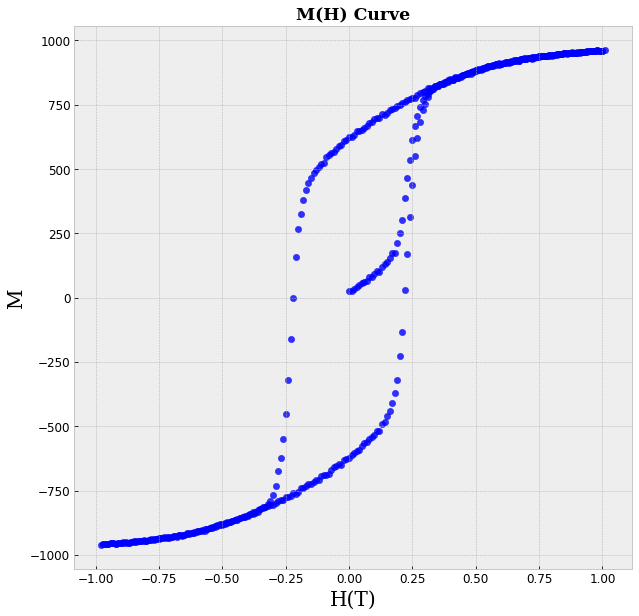

In [8]:
# PLOTTING HYSTERESIS LOOP
plt.style.use("bmh")
ax = df.plot.scatter(x='Hext',y='MagTotal',alpha=0.8, figsize=(10,10), fontsize=12, s=40)
ax.set_title('M(H) Curve', size="xx-large", family="serif", weight= "semibold")
plt.xlabel('H(T)', fontsize= 20, color="#000000", family="serif")
plt.ylabel('M', fontsize= 20, color="#000000", family="serif")
plt.show()

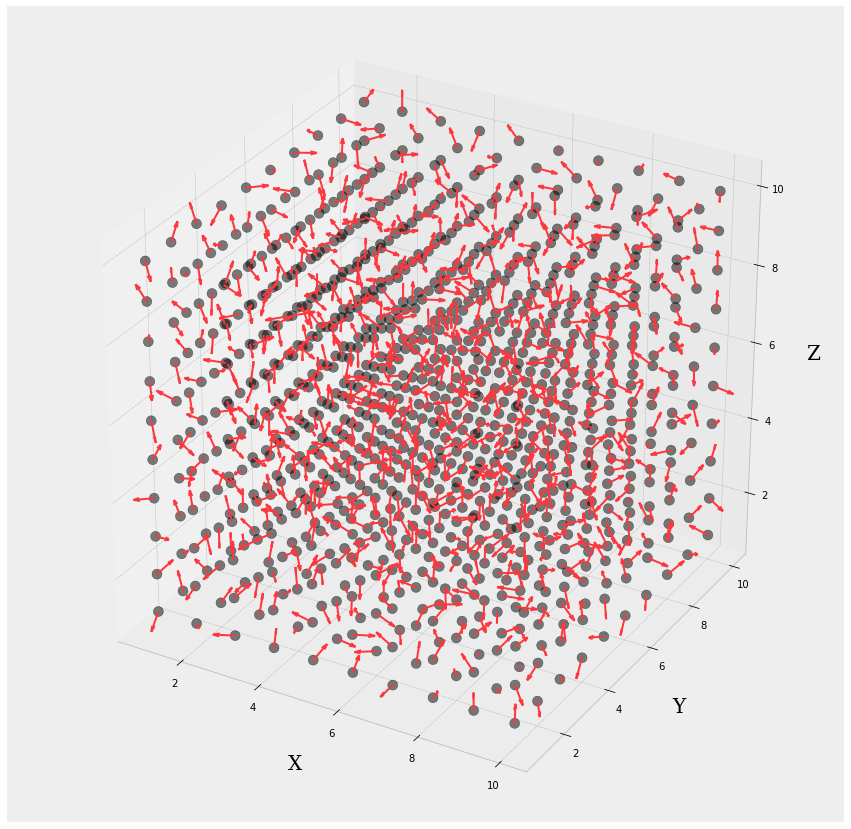

In [9]:
# ============= PLOTTING INITIAL CONFIGURATION =============
#Normal 3D plot
%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=0.5, color="k")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.5, color='#FC383E')
#ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
plt.savefig('3d.png')
plt.show()